In [ ]:
# Bloco 1 – Instalação de dependências
!pip install pandas numpy scikit-learn imblearn statsmodels matplotlib seaborn streamlit


In [ ]:
# Bloco 2 – Importações e Configurações

# 1) Controle de warnings e logs
import warnings
warnings.filterwarnings("ignore")               # Suprime FutureWarnings e similares
import logging
logging.getLogger("streamlit").setLevel(logging.ERROR)

# 2) Bibliotecas gerais
import os
import pandas as pd
import numpy as np

# 3) Visualização (notebook e app)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# 4) Modelagem e pré-processamento
from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.linear_model          import LogisticRegression
from sklearn.feature_selection     import RFE
from sklearn.metrics               import (
    roc_auc_score, roc_curve,
    confusion_matrix,
    classification_report,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling        import SMOTE
import statsmodels.api             as sm

# 5) Estatística complementar
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 6) Dashboard interativo
import streamlit as st
st.set_page_config(page_title="Dashboard de Cancelamentos", layout="wide")

# 7) Constantes
RANDOM_STATE = 42
TEST_SIZE    = 0.3


2025-06-16 23:00:30.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
# Bloco 3 – Carregamento do CSV e Resumo Rápido

# Detecta automaticamente onde está o arquivo
if os.path.exists('/content/sample_data/hotel_bookings.csv'):
    path = '/content/sample_data/hotel_bookings.csv'
elif os.path.exists('hotel_bookings.csv'):
    path = 'hotel_bookings.csv'
else:
    raise FileNotFoundError("Arquivo 'hotel_bookings.csv' não encontrado.")

# Carrega o DataFrame, já parseando datas
df = pd.read_csv(path, parse_dates=['reservation_status_date'])

# Exibe apenas um resumo enxuto
print("Shape:", df.shape)
print("\nColunas:", df.columns.tolist())
print("\nMissings por coluna:\n", df.isna().sum())
print("\nDistribuição de is_canceled (proporção):")
print(df['is_canceled'].value_counts(normalize=True).round(3))
print("\nAmostra das 5 primeiras linhas:")
print(df.head(5))


Shape: (119390, 32)

Colunas: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date']

Missings por coluna:
 hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0


In [ ]:
# Bloco 4 – Limpeza de outliers e tratamento de missing

def clean_data(df):
    """
    Remove registros inválidos e trata valores faltantes:
    - Filtra tarifas diárias negativas (adr < 0)
    - Preenche missing em agent e company com 0 (reservas sem agência/empresa)
    - Agrupa países fora do top 10 em 'Other'
    """
    # Remove outliers de ADR
    df = df[df['adr'] >= 0].copy()

    # Imputa missing de agent e company
    df['agent'].fillna(0, inplace=True)
    df['company'].fillna(0, inplace=True)

    # Agrupa países menos frequentes
    top_countries = df['country'].value_counts().nlargest(10).index
    df['country'] = df['country'].where(df['country'].isin(top_countries), 'Other')

    return df

# Aplica limpeza
df = clean_data(df)

# Resumo pós-limpeza
print("Após limpeza: Shape =", df.shape)
print("Missings remaining:\n", df.isna().sum())


Após limpeza: Shape = (119389, 32)
Missings remaining:
 hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer

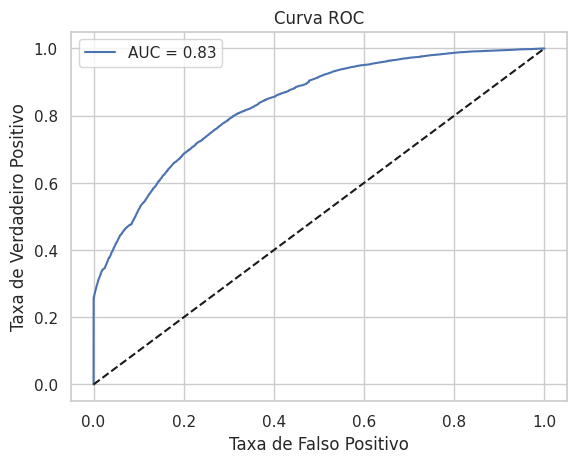

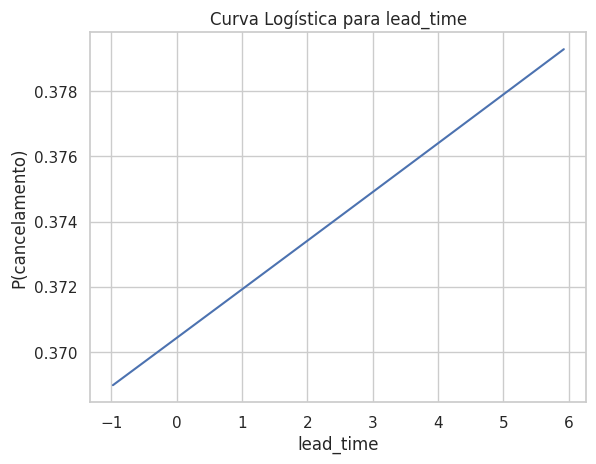

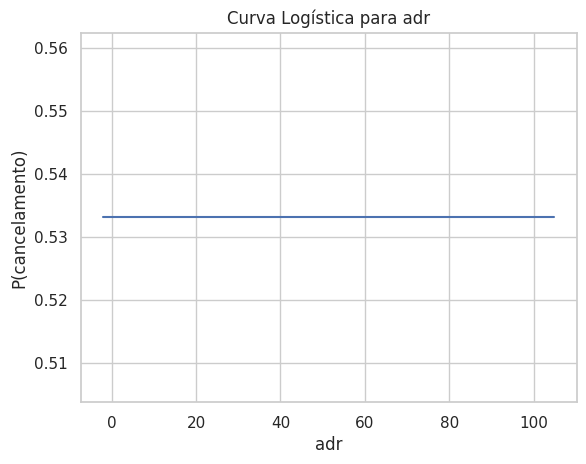

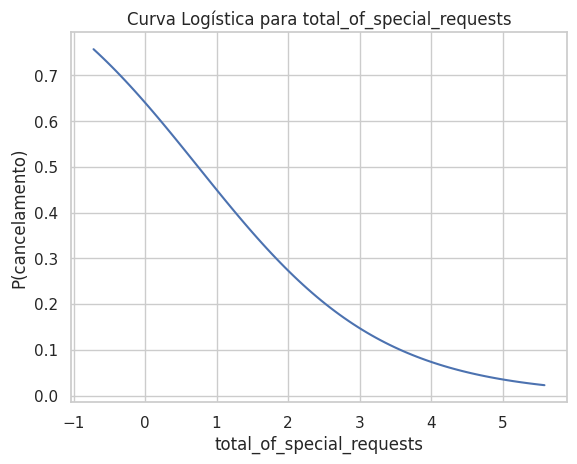

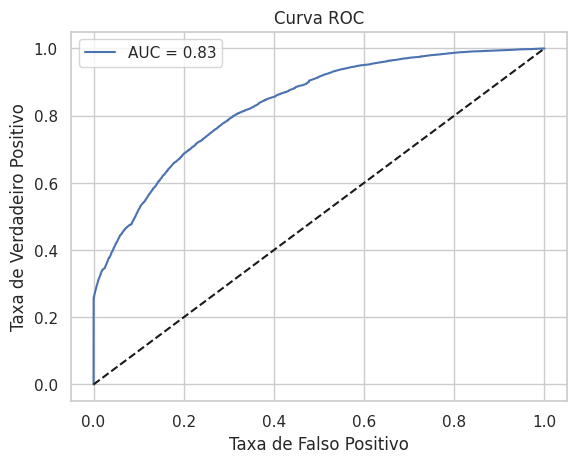

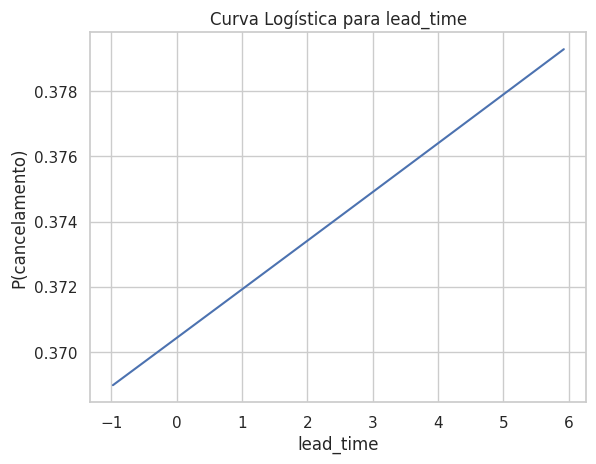

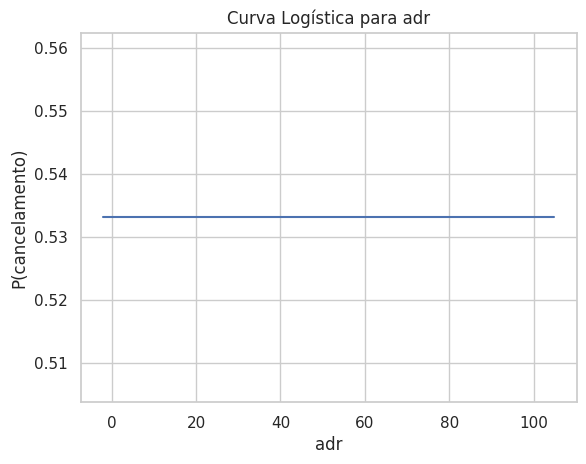

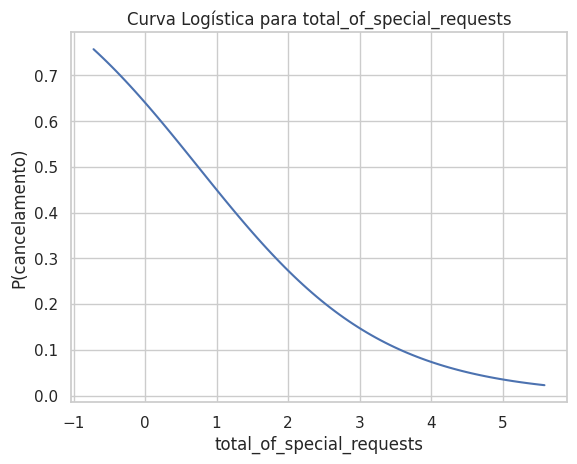

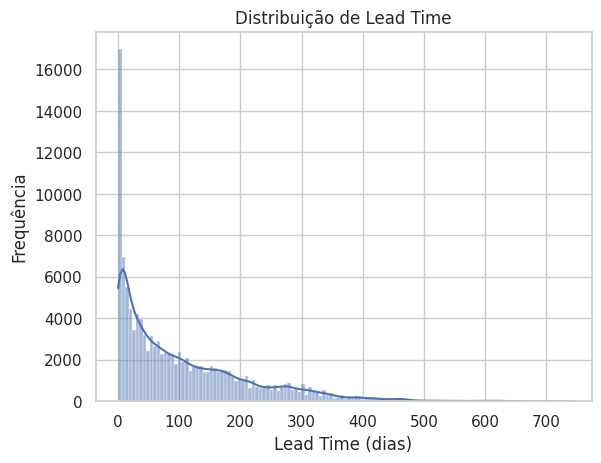

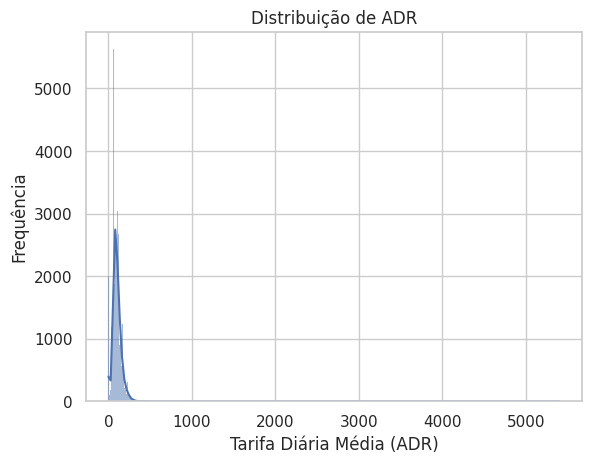

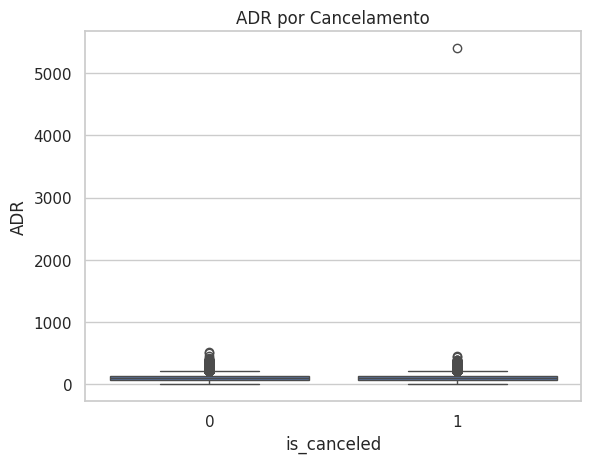

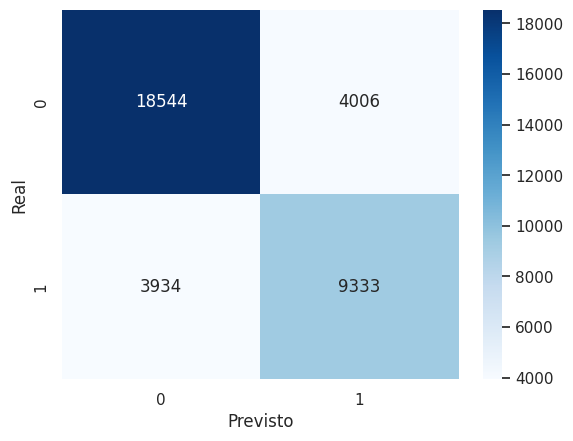

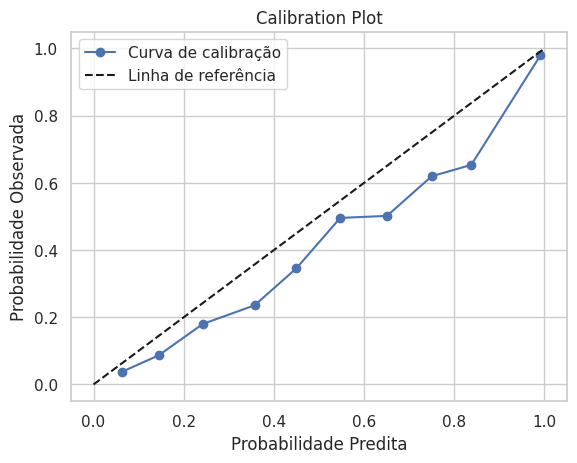

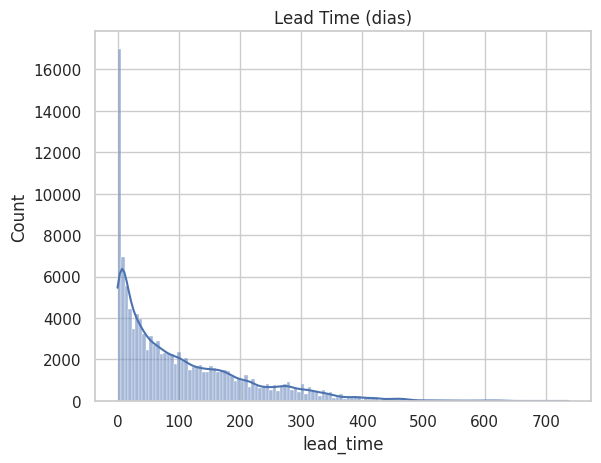

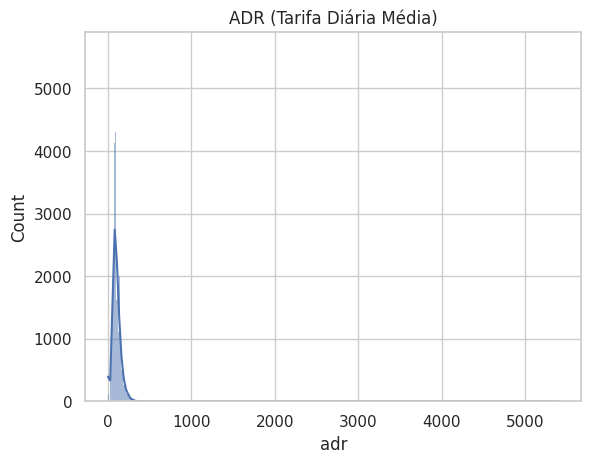

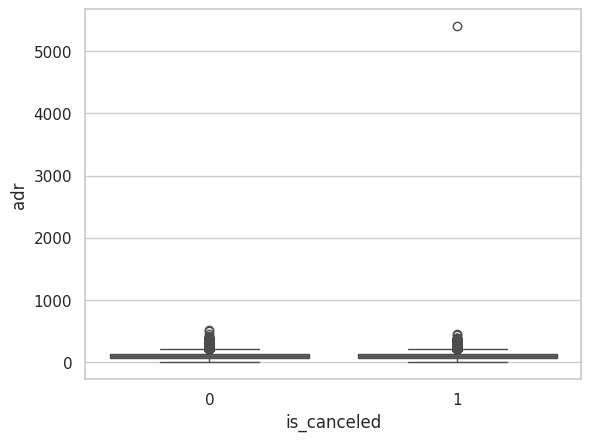

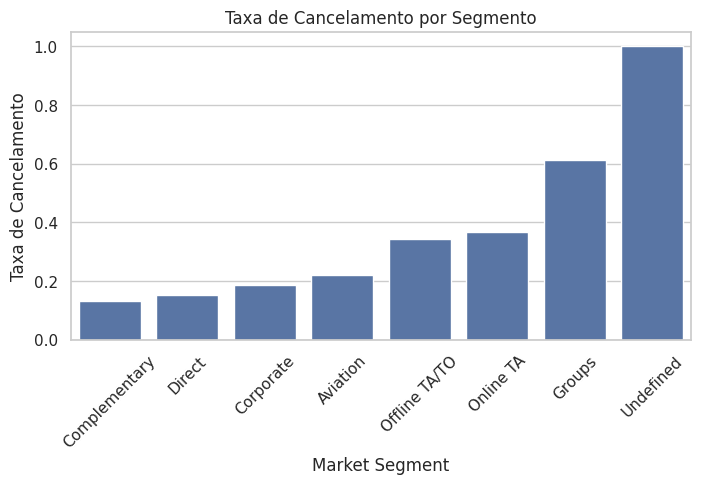

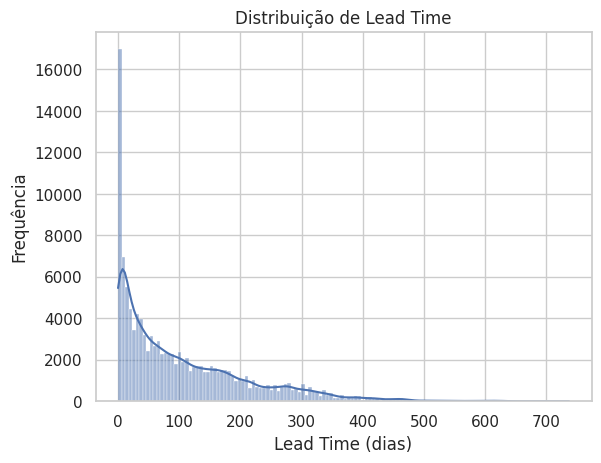

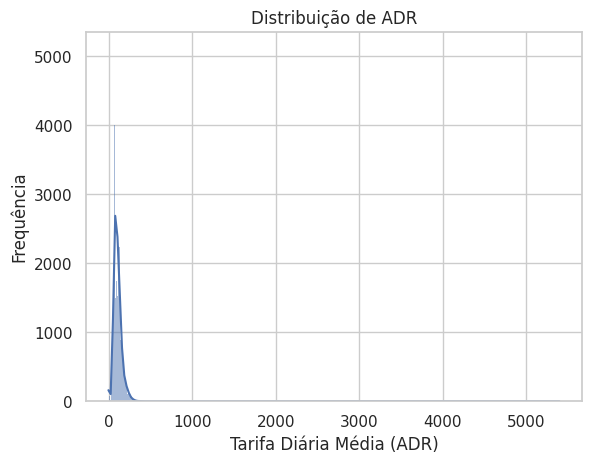

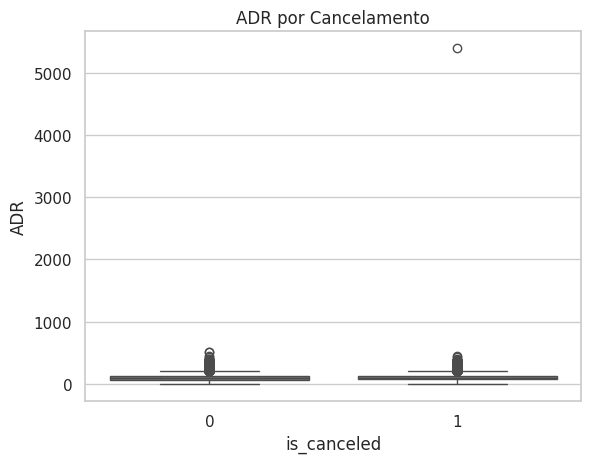

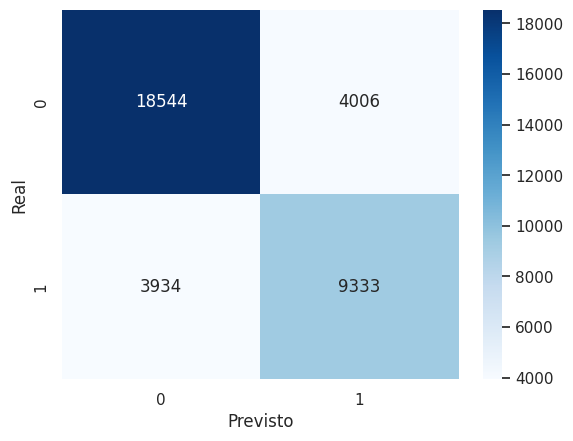

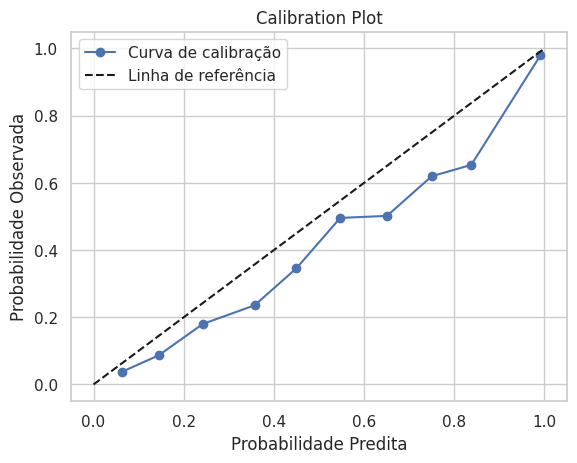

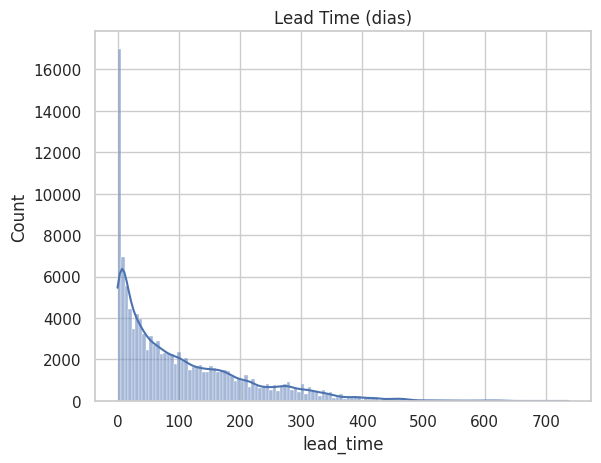

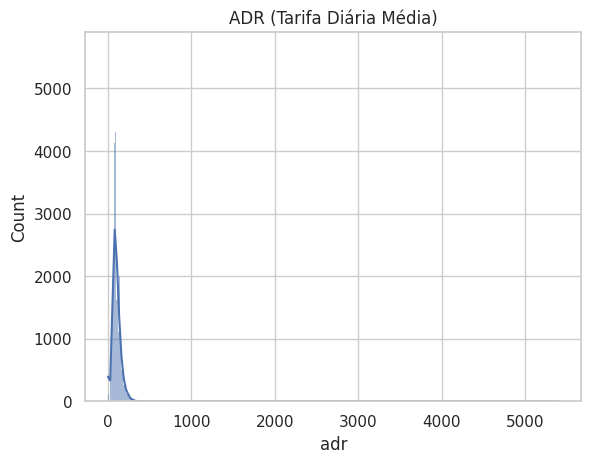

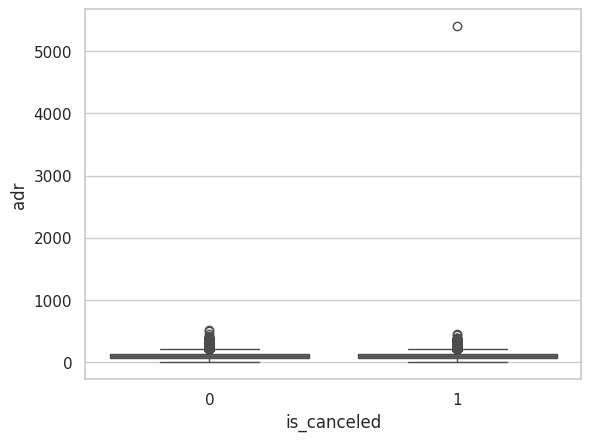

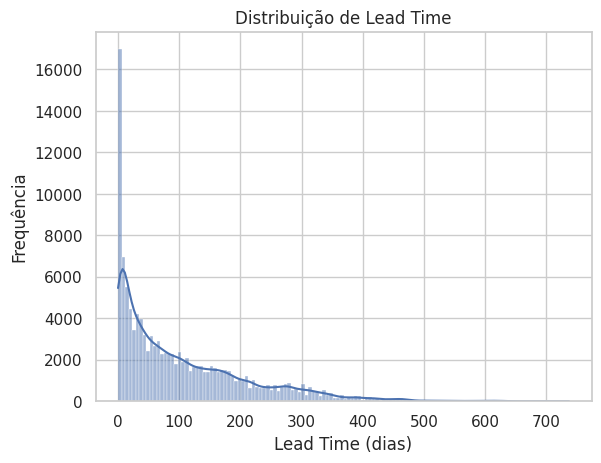

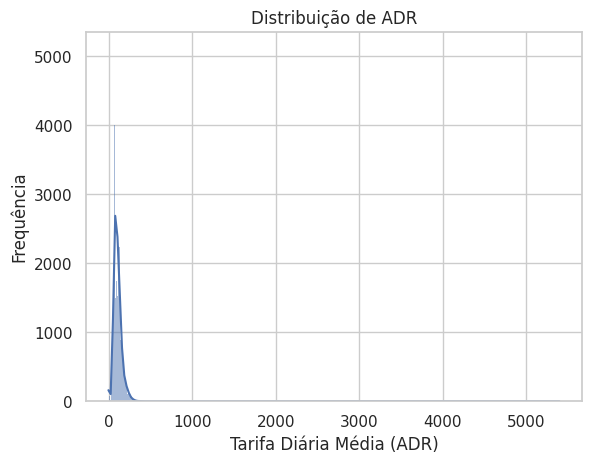

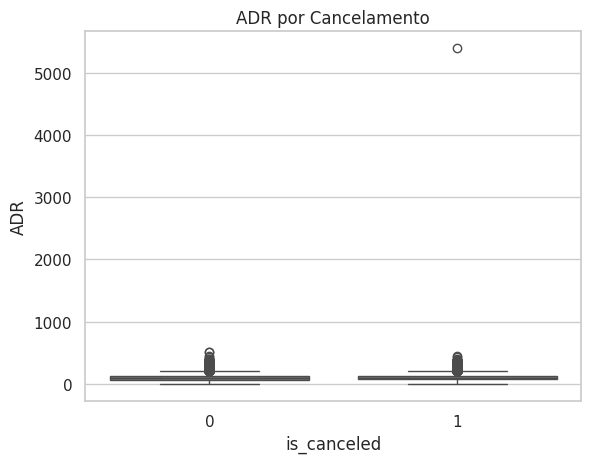

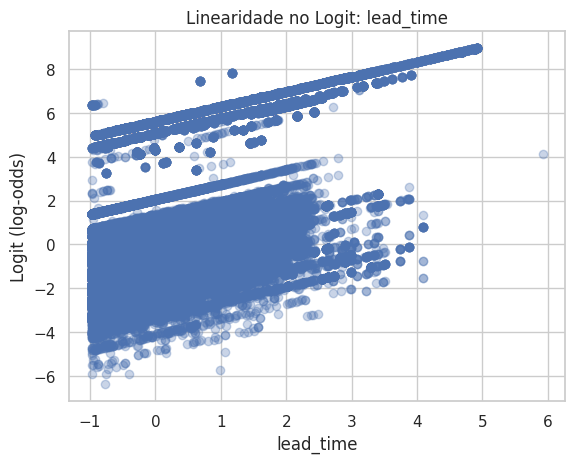

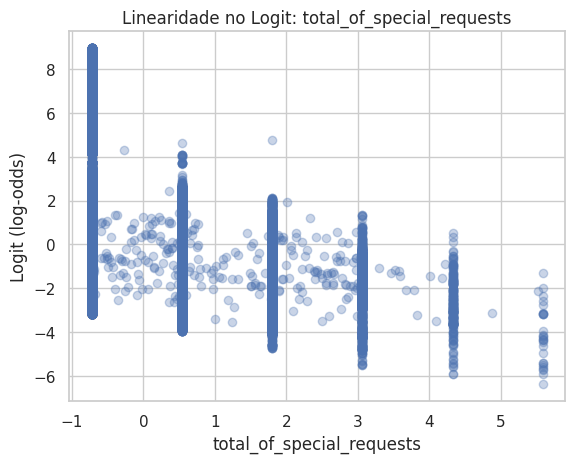

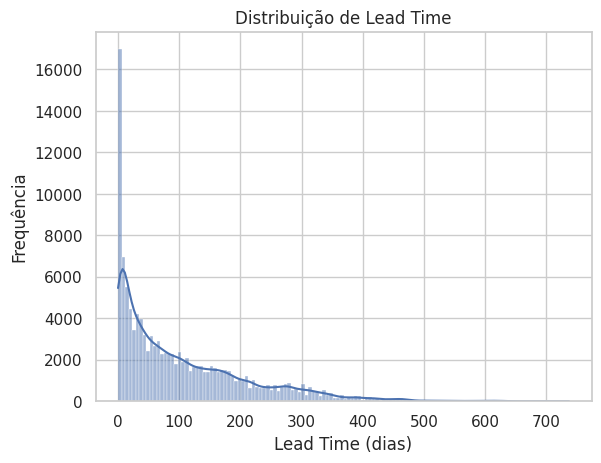

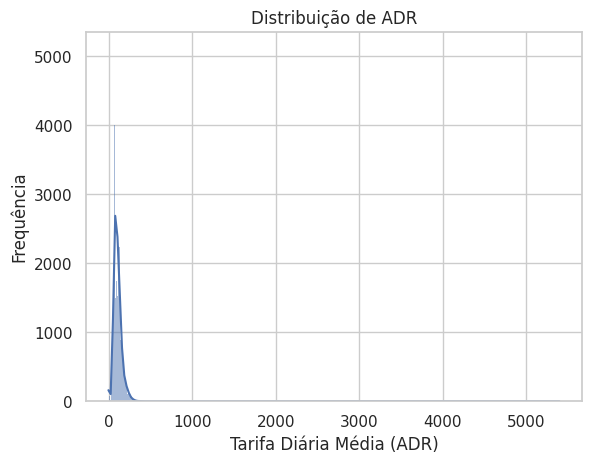

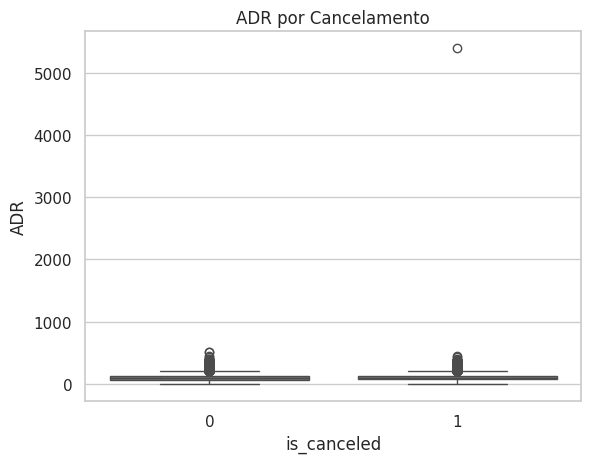

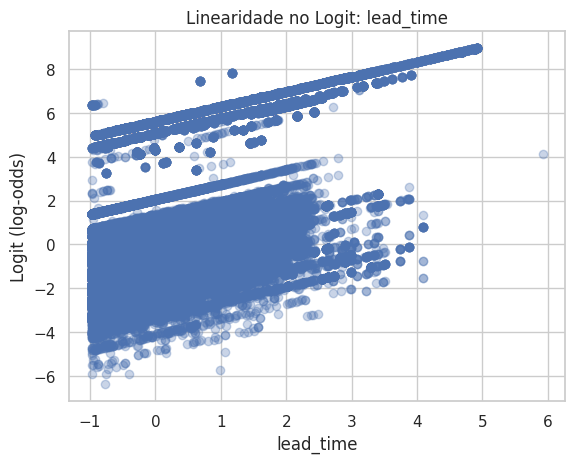

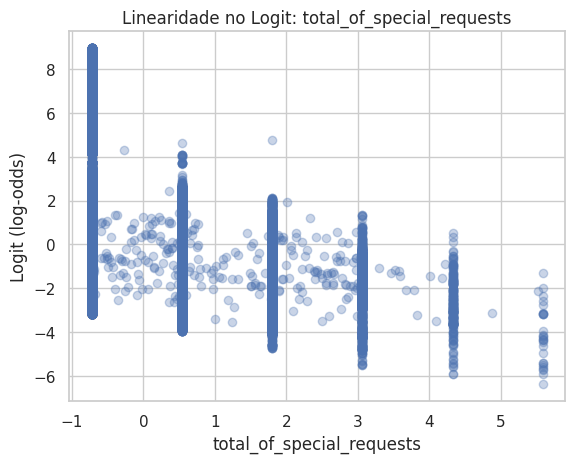

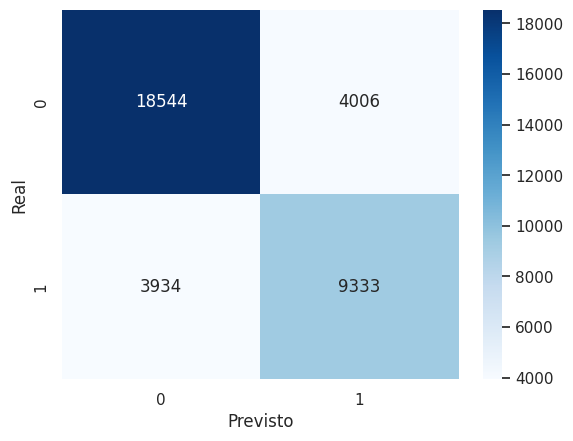

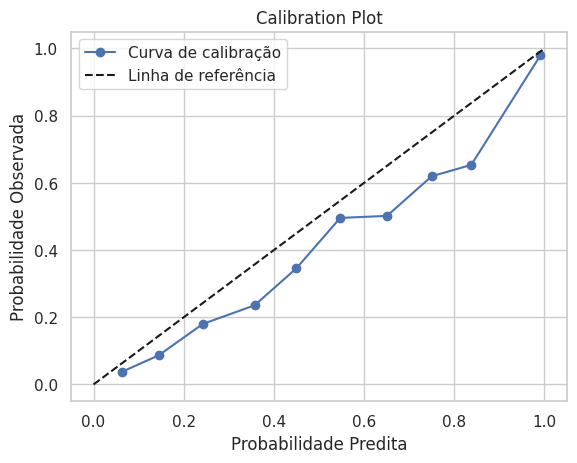

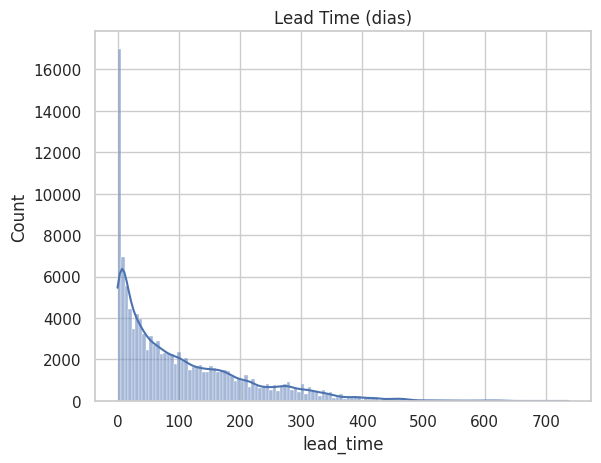

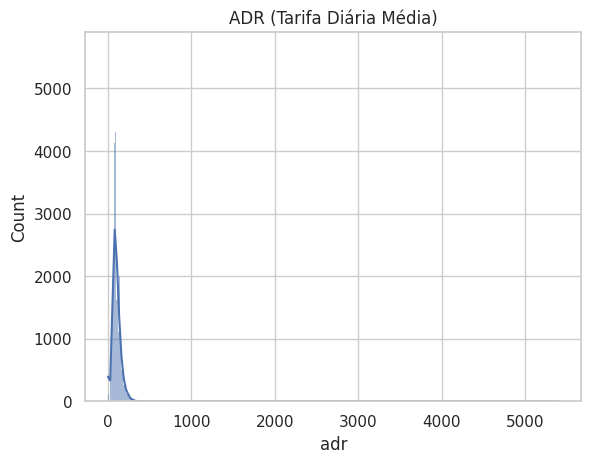

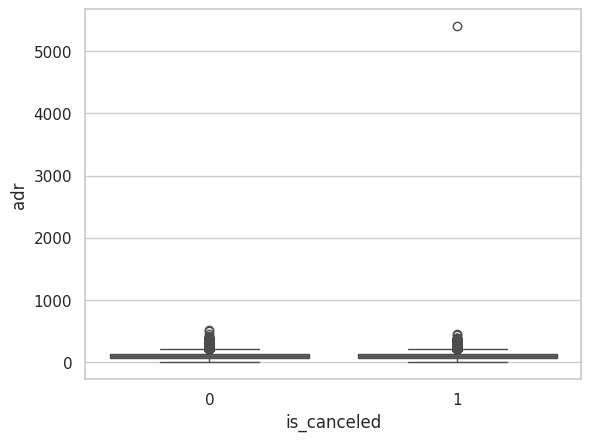

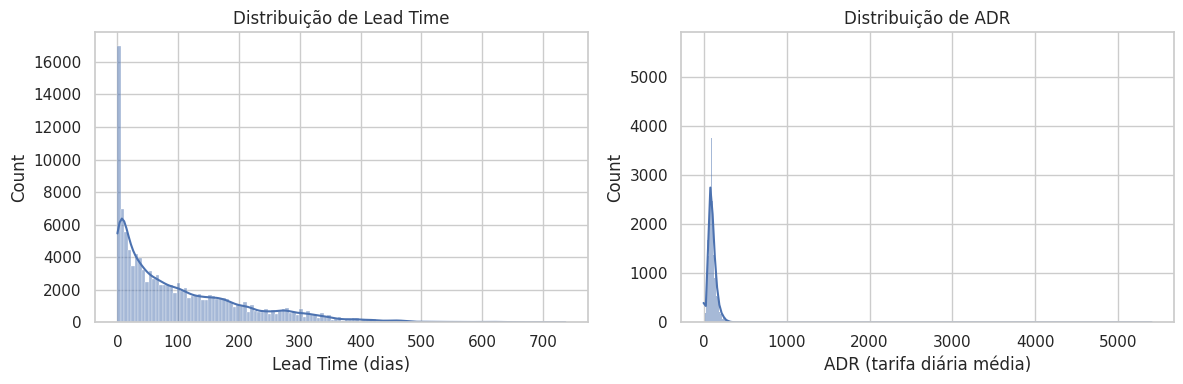

Taxa de cancelamento por Market Segment:
market_segment
Complementary    0.131
Direct           0.153
Corporate        0.187
Aviation         0.219
Offline TA/TO    0.343
Online TA        0.367
Groups           0.611
Undefined        1.000
Name: is_canceled, dtype: float64


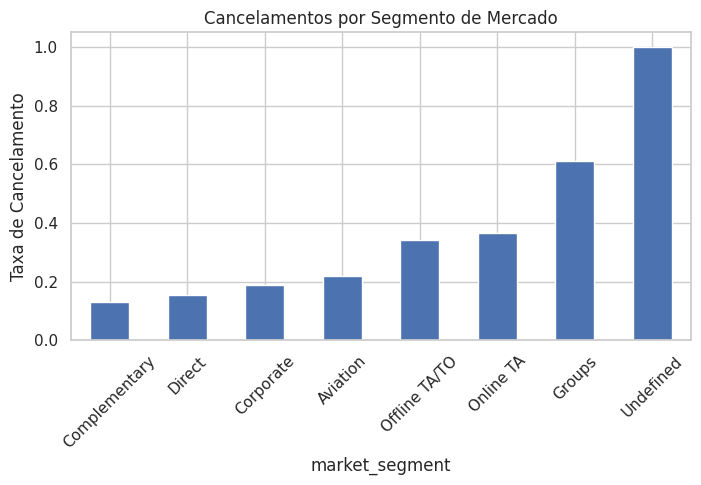


Taxa de cancelamento por Mês de Chegada:
is_canceled            0     1
arrival_date_month            
April               0.59  0.41
August              0.62  0.38
December            0.65  0.35
February            0.67  0.33
January             0.70  0.30
July                0.63  0.37
June                0.59  0.41
March               0.68  0.32
May                 0.60  0.40
November            0.69  0.31
October             0.62  0.38
September           0.61  0.39


In [ ]:
# Bloco 5 – EDA Estático

# 1) Histogramas de variáveis contínuas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['lead_time'], kde=True, ax=axes[0])
axes[0].set_title('Distribuição de Lead Time')
axes[0].set_xlabel('Lead Time (dias)')
sns.histplot(df['adr'], kde=True, ax=axes[1])
axes[1].set_title('Distribuição de ADR')
axes[1].set_xlabel('ADR (tarifa diária média)')
plt.tight_layout()
plt.show()

# 2) Taxa de cancelamento por Market Segment
seg_rate = df.groupby('market_segment')['is_canceled'].mean().sort_values()
print("Taxa de cancelamento por Market Segment:")
print(seg_rate.round(3))

# Gráfico de barras
fig, ax = plt.subplots(figsize=(8, 4))
seg_rate.plot.bar(ax=ax)
ax.set_ylabel('Taxa de Cancelamento')
ax.set_title('Cancelamentos por Segmento de Mercado')
plt.xticks(rotation=45)
plt.show()

# 3) Tabela de contingência resumida por mês de chegada
ct = pd.crosstab(
    df['arrival_date_month'],
    df['is_canceled'],
    normalize='index'
).round(2)
print("\nTaxa de cancelamento por Mês de Chegada:")
print(ct)


In [ ]:
# Bloco 6 – Pré-processamento: encoding, padronização e definição de X e y

# 1) Definição de variáveis contínuas e categóricas
cont_vars = ['lead_time', 'adr', 'total_of_special_requests']
cat_vars  = ['hotel', 'arrival_date_month', 'market_segment', 'customer_type', 'deposit_type', 'country']

# 2) Seleção do subset de features
df_features = df[cont_vars + cat_vars].copy()

# 3) One-hot encoding para variáveis categóricas
df_encoded = pd.get_dummies(df_features, columns=cat_vars, drop_first=True)

# 4) Padronização das variáveis contínuas
scaler = StandardScaler()
df_encoded[cont_vars] = scaler.fit_transform(df_encoded[cont_vars])

# 5) Definição de X e y
X = df_encoded
y = df['is_canceled']

# 6) Resumo rápido
print("X shape:", X.shape)
print("Distribuição de y (proporção):\n", y.value_counts(normalize=True).round(3))
print("Exemplo de X.head():")
print(X.head())


X shape: (119389, 37)
Distribuição de y (proporção):
 is_canceled
0    0.63
1    0.37
Name: proportion, dtype: float64
Exemplo de X.head():
   lead_time       adr  total_of_special_requests  hotel_Resort Hotel  \
0   2.227056 -2.015086                  -0.720699                True   
1   5.923385 -2.015086                  -0.720699                True   
2  -0.907806 -0.530961                  -0.720699                True   
3  -0.851659 -0.530961                  -0.720699                True   
4  -0.842301 -0.075829                   0.540659                True   

   arrival_date_month_August  arrival_date_month_December  \
0                      False                        False   
1                      False                        False   
2                      False                        False   
3                      False                        False   
4                      False                        False   

   arrival_date_month_February  arrival_date_month_Jan

In [ ]:
# Bloco 7 – Divisão treino/teste e tratamento de desbalanceamento (SMOTE)

# 1) Divisão estratificada com shuffle para reprodutibilidade
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    shuffle=True,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Conjuntos após split:")
print(f"- X_train: {X_train.shape}   y_train: {y_train.shape}")
print(f"- X_test : {X_test.shape}   y_test : {y_test.shape}")
print("\nDistribuição de y_train (proporção):")
print(y_train.value_counts(normalize=True).round(3))

# 2) Aplicação de SMOTE no conjunto de treino para equilibrar classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("\nApós SMOTE:")
print(f"- X_res : {X_res.shape}   y_res : {y_res.shape}")
print("Distribuição de y_res (proporção):")
print(y_res.value_counts(normalize=True).round(3))


Conjuntos após split:
- X_train: (83572, 37)   y_train: (83572,)
- X_test : (35817, 37)   y_test : (35817,)

Distribuição de y_train (proporção):
is_canceled
0    0.63
1    0.37
Name: proportion, dtype: float64

Após SMOTE:
- X_res : (105230, 37)   y_res : (105230,)
Distribuição de y_res (proporção):
is_canceled
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
# Bloco 8 – Seleção de Features com RFE

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import pandas as pd

# 1) Modelo base para RFE
base_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# 2) Instancia e ajusta o RFE para selecionar as 12 variáveis mais importantes
rfe = RFE(estimator=base_model, n_features_to_select=12)
rfe.fit(X_res, y_res)

# 3) Extrai lista de features selecionadas
selected_features = X_res.columns[rfe.support_].tolist()
print("Features selecionadas pelo RFE (n=12):")
print(selected_features)

# 4) Ranking completo das variáveis
ranking_df = pd.DataFrame({
    'feature': X_res.columns,
    'ranking': rfe.ranking_
}).sort_values('ranking')
print("\nRanking de todas as variáveis (1 = mais importante):")
print(ranking_df)


Features selecionadas pelo RFE (n=12):
['lead_time', 'total_of_special_requests', 'market_segment_Groups', 'market_segment_Online TA', 'customer_type_Transient', 'deposit_type_Non Refund', 'country_BRA', 'country_ESP', 'country_IRL', 'country_ITA', 'country_Other', 'country_PRT']

Ranking de todas as variáveis (1 = mais importante):
                          feature  ranking
0                       lead_time        1
2       total_of_special_requests        1
29                    country_ESP        1
27                    country_BRA        1
25        deposit_type_Non Refund        1
23        customer_type_Transient        1
20       market_segment_Online TA        1
18          market_segment_Groups        1
36                    country_PRT        1
35                  country_Other        1
33                    country_ITA        1
32                    country_IRL        1
3              hotel_Resort Hotel        2
17          market_segment_Direct        3
19   market_segment_

In [ ]:
# Bloco 9 – Ajuste do modelo e extração de coeficientes

# 1) Seleção de features e target
X_sel = X_res[selected_features]
y_sel = y_res

# 2) Garante que tudo é float (elimina object dtypes)
X_sel = X_sel.astype(float)
y_sel = y_sel.astype(float)

# 3) Adiciona intercepto
X_sm = sm.add_constant(X_sel)

# 4) Ajusta o modelo Logit (MQP)
logit_model  = sm.Logit(y_sel, X_sm)
logit_result = logit_model.fit(disp=False)

# 5) Monta DataFrame de coeficientes, p-valores e odds ratios
coef_df = pd.DataFrame({
    'log_odds'   : logit_result.params,
    'p_value'    : logit_result.pvalues,
    'odds_ratio' : np.exp(logit_result.params)
}).sort_values('odds_ratio', ascending=False)

# 6) Exibe de forma enxuta
print("Coeficientes do Modelo (ordenados por odds_ratio):")
print(coef_df[['log_odds', 'p_value', 'odds_ratio']]
      .round({'log_odds': 3, 'p_value': 3, 'odds_ratio': 2}))


Coeficientes do Modelo (ordenados por odds_ratio):
                           log_odds  p_value  odds_ratio
deposit_type_Non Refund       4.956      0.0      141.96
country_PRT                   1.959      0.0        7.09
market_segment_Online TA      1.939      0.0        6.95
country_BRA                   1.005      0.0        2.73
country_ITA                   0.930      0.0        2.53
lead_time                     0.681      0.0        1.98
customer_type_Transient       0.669      0.0        1.95
country_ESP                   0.653      0.0        1.92
country_Other                 0.554      0.0        1.74
market_segment_Groups         0.536      0.0        1.71
country_IRL                   0.389      0.0        1.48
total_of_special_requests    -0.616      0.0        0.54
const                        -2.963      0.0        0.05


VIF das Features Selecionadas:
                      feature   VIF
4     customer_type_Transient  4.34
3    market_segment_Online TA  3.04
5     deposit_type_Non Refund  2.44
11                country_PRT  2.37
2       market_segment_Groups  1.82
10              country_Other  1.40
0                   lead_time  1.32
1   total_of_special_requests  1.22
7                 country_ESP  1.19
9                 country_ITA  1.08
8                 country_IRL  1.07
6                 country_BRA  1.06


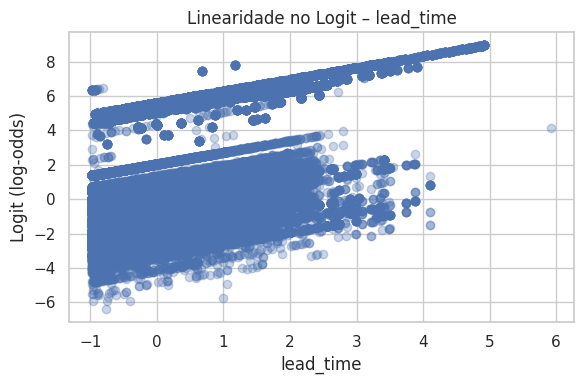

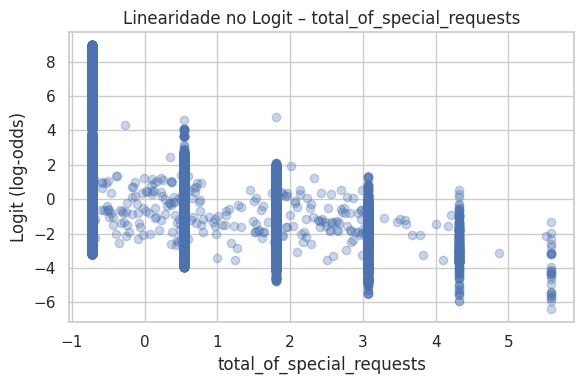

Pseudo-R² (McFadden): 0.335
AIC: 97050.6    BIC: 97175.0


In [ ]:
# Bloco 10 – Diagnósticos: VIF, Linearidade Gráfica e Qualidade de Ajuste

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Multicolinearidade – VIF
X_vif = X_sel.copy()  # X_sel e y_sel definidos no Bloco 9
vif_df = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)
print("VIF das Features Selecionadas:")
print(vif_df.round(2))

# 2) Linearidade no Logit – gráficos de logit vs features contínuas
lin_pred = X_sm.dot(logit_result.params)  # X_sm e logit_result do Bloco 9
cont_in_model = [v for v in cont_vars if v in selected_features]

for var in cont_in_model:
    plt.figure(figsize=(6,4))
    plt.scatter(X_sel[var], lin_pred, alpha=0.3)
    plt.xlabel(var)
    plt.ylabel("Logit (log-odds)")
    plt.title(f"Linearidade no Logit – {var}")
    plt.tight_layout()
    plt.show()

# 3) Qualidade de Ajuste – Pseudo-R² e AIC/BIC
print(f"Pseudo-R² (McFadden): {logit_result.prsquared:.3f}")
print(f"AIC: {logit_result.aic:.1f}    BIC: {logit_result.bic:.1f}")


Métricas no conjunto de teste:
 Acurácia : 0.778
 Precisão : 0.700
 Recall   : 0.703
 F1-score : 0.702
 AUC (ROC): 0.847


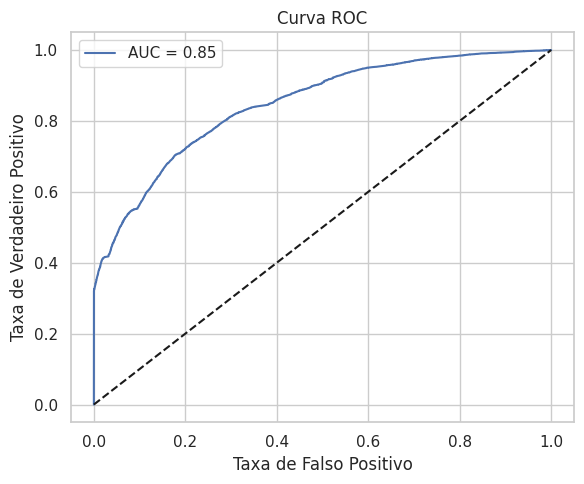

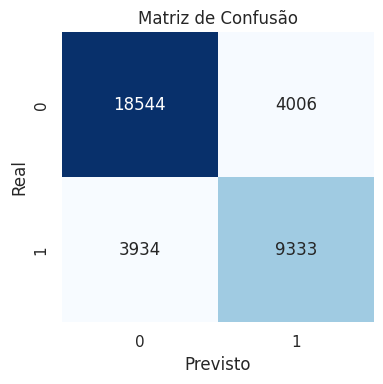

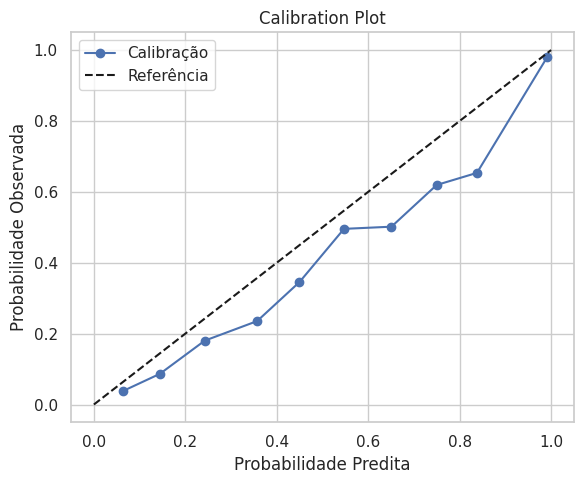

In [ ]:
# Bloco 11 – Avaliação preditiva: métricas, ROC, matriz de confusão e calibration plot

from sklearn.linear_model      import LogisticRegression
from sklearn.metrics           import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.calibration       import calibration_curve
import matplotlib.pyplot       as plt
import seaborn                 as sns

# 1) Treina o classificador no conjunto balanceado
clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
clf.fit(X_res[selected_features], y_res)

# 2) Previsões no conjunto de teste
y_pred_prob = clf.predict_proba(X_test[selected_features])[:, 1]
y_pred      = (y_pred_prob >= 0.5).astype(int)

# 3) Cálculo das métricas principais
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
auc       = roc_auc_score(y_test, y_pred_prob)

print("Métricas no conjunto de teste:")
print(f" Acurácia : {accuracy:.3f}")
print(f" Precisão : {precision:.3f}")
print(f" Recall   : {recall:.3f}")
print(f" F1-score : {f1:.3f}")
print(f" AUC (ROC): {auc:.3f}")

# 4) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend()
plt.tight_layout()
plt.show()

# 5) Matriz de Confusão (heatmap)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

# 6) Calibration Plot
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10, strategy='uniform')
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibração')
plt.plot([0,1],[0,1], 'k--', label='Referência')
plt.xlabel("Probabilidade Predita")
plt.ylabel("Probabilidade Observada")
plt.title("Calibration Plot")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Bloco 12 – App Streamlit: layout em abas, filtros e KPIs

# --- Sidebar de filtros ---
st.sidebar.header("Filtros de Entrada")

# Lead time
lead_min, lead_max = st.sidebar.slider(
    "Lead time (dias)",
    int(df['lead_time'].min()),
    int(df['lead_time'].max()),
    (int(df['lead_time'].quantile(0.1)), int(df['lead_time'].quantile(0.9)))
)

# Market segment
segments = st.sidebar.multiselect(
    "Market Segment",
    options=df['market_segment'].unique(),
    default=df['market_segment'].unique()
)

# Cutoff de decisão
cutoff = st.sidebar.slider(
    "Cutoff de Probabilidade",
    min_value=0.0, max_value=1.0,
    value=0.5, step=0.01
)

# --- Aplica filtros ---
mask = (
    (df['lead_time'] >= lead_min) &
    (df['lead_time'] <= lead_max) &
    (df['market_segment'].isin(segments))
)
df_filt = df.loc[mask]

# Prepara Xf e probabilidades
Xf = df_encoded.loc[df_filt.index, selected_features]
yf_prob = clf.predict_proba(Xf[selected_features])[:, 1]
df_filt = df_filt.assign(pred_cancel_prob=yf_prob)

# Classificação de risco
df_filt['risk_level'] = pd.cut(
    df_filt['pred_cancel_prob'],
    bins=[0, 0.33, 0.66, 1.0],
    labels=['Baixo', 'Médio', 'Alto']
)

# --- Abas principais ---
tabs = st.tabs(["EDA", "Modelagem", "Dashboard"])

# Aba 1: EDA
with tabs[0]:
    st.header("🔍 Exploração de Dados")
    st.subheader("Cancelamentos por Segmento")
    seg_rate = df_filt['market_segment'].value_counts().reindex(segments).fillna(0)
    st.bar_chart(seg_rate)

    st.subheader("Histograma de Lead Time & ADR")
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df_filt['lead_time'], kde=True, ax=axes[0]).set(title="Lead Time")
    sns.histplot(df_filt['adr'], kde=True, ax=axes[1]).set(title="ADR")
    st.pyplot(fig)

    st.subheader("Classificação de Risco")
    st.dataframe(df_filt['risk_level'].value_counts(normalize=True)
                 .rename("Proporção").to_frame().style.format("{:.2%}"))

# Aba 2: Modelagem
with tabs[1]:
    st.header("⚙️ Modelagem e Diagnósticos")
    st.subheader("Seleção de Features")
    st.write("Manual:", cont_vars + cat_vars)
    st.write("RFE   :", selected_features)

    st.subheader("Coeficientes e Odds Ratios")
    st.dataframe(coef_df.round({'log_odds':3,'p_value':3,'odds_ratio':2}))

    st.subheader("VIF das Features Selecionadas")
    st.dataframe(vif_df.round(2))

    st.subheader("Ajuste do Modelo")
    st.write(f"Pseudo-R²: {logit_result.prsquared:.3f}")
    st.write(f"AIC: {logit_result.aic:.0f}   BIC: {logit_result.bic:.0f}")

# Aba 3: Dashboard Interativo
with tabs[2]:
    st.header("📊 Avaliação Preditiva")
    # Métricas com cutoff
    y_pred_thresh = (yf_prob >= cutoff).astype(int)
    precision = precision_score(df_filt['is_canceled'], y_pred_thresh)
    recall    = recall_score(df_filt['is_canceled'], y_pred_thresh)
    f1        = f1_score(df_filt['is_canceled'], y_pred_thresh)
    auc_val   = roc_auc_score(df_filt['is_canceled'], yf_prob)

    c1, c2, c3, c4 = st.columns(4)
    c1.metric("AUC", f"{auc_val:.2f}")
    c2.metric("Precisão", f"{precision:.2f}")
    c3.metric("Recall", f"{recall:.2f}")
    c4.metric("F1-score", f"{f1:.2f}")

    st.subheader(f"Matriz de Confusão (cutoff={cutoff:.2f})")
    cm = confusion_matrix(df_filt['is_canceled'], y_pred_thresh)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Previsto")
    ax.set_ylabel("Real")
    st.pyplot(fig)

    st.subheader("Curva ROC")
    plot_roc_curve(df_filt['is_canceled'], yf_prob)

    st.subheader("Curvas Logísticas de Variáveis-Chave")
    for var in cont_vars:
        plot_logistic_curve(var, df_encoded, scaler, clf, selected_features, cont_vars)


2025-06-16 23:14:39.046 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.050 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.059 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.063 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.064 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-16 23:14:39.088 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar